**EDA - AirBnB pricing project**

In [3]:
# load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

In [4]:
# load data
path_data = '../Data/'

#list of all data names
city_data = ['jc_listings','jc_calendar','jc_locale','jc_reviews',
             'nyc_listings','nyc_calendar','nyc_locale','nyc_reviews',
             'rio_listings','rio_calendar','rio_locale','rio_reviews']
                   
dfs = {}

# loop to load all the data with respective name
for city in city_data:
    dfs[city] = pd.read_pickle(path_data+city+'.pkl')    
    
for key,val in dfs.items():
    exec(key + '=val')

In [5]:
# delete dfs dictionary to free memory
del dfs

*Sasonality Analisis*

In [6]:
#inspecting the data frames
jc_calendar.info(),nyc_calendar.info(),rio_calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 935900 entries, 0 to 935899
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   listing_id      935900 non-null  int64  
 1   date            935900 non-null  object 
 2   available       935900 non-null  object 
 3   price           935729 non-null  object 
 4   adjusted_price  935729 non-null  object 
 5   minimum_nights  935177 non-null  float64
 6   maximum_nights  935177 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 50.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14551462 entries, 0 to 14551461
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   listing_id      int64  
 1   date            object 
 2   available       object 
 3   price           object 
 4   adjusted_price  object 
 5   minimum_nights  float64
 6   maximum_nights  float64
dtypes: float64(2), int64(1), object(4

(None, None, None)

In [7]:
# Only keep selected listing id 
jc_calendar = jc_calendar[jc_calendar['listing_id'].isin(jc_listings['id'])]
nyc_calendar = nyc_calendar[nyc_calendar['listing_id'].isin(nyc_listings['id'])]
rio_calendar = rio_calendar[rio_calendar['listing_id'].isin(rio_listings['id'])]

The date and price are objects, will transform them in datetime and float object types

In [8]:
# changing date column to pandas datetime object
jc_calendar['date'] = pd.to_datetime(jc_calendar['date']) 
nyc_calendar['date'] = pd.to_datetime(nyc_calendar['date'])
rio_calendar['date'] = pd.to_datetime(rio_calendar['date'])

In [9]:
# changing price column to a float object
jc_calendar['price'] = jc_calendar.price.replace({'\$': '',',':''},regex=True).astype(float)
nyc_calendar['price'] = nyc_calendar.price.replace({'\$': '',',':''},regex=True).astype(float)
rio_calendar['price'] = rio_calendar.price.replace({'\$': '',',':''},regex=True).astype(float)

In [10]:
# changing adjusted price to a float object
jc_calendar['adjusted_price'] = jc_calendar.adjusted_price.replace({'\$': '',',':''},regex=True).astype(float)
nyc_calendar['adjusted_price'] = nyc_calendar.adjusted_price.replace({'\$': '',',':''},regex=True).astype(float)
rio_calendar['adjusted_price'] = rio_calendar.adjusted_price.replace({'\$': '',',':''},regex=True).astype(float)

In [11]:
# saving changes calendar dataset for later use

jc_calendar.to_pickle(path_data+'jc_calendar.pkl')
nyc_calendar.to_pickle(path_data+'nyc_calendar.pkl')
rio_calendar.to_pickle(path_data+'rio_calendar.pkl')

Visual analysis of aggregated time series of listing prices

Prices distribution isn't symetric; therefore, we will examine the mean and median.

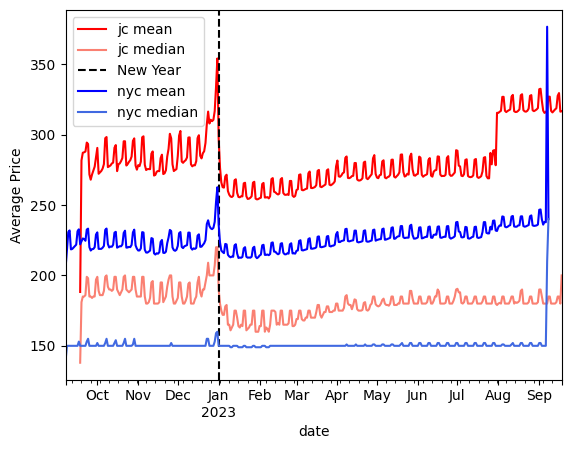

In [12]:
jc_calendar.groupby('date')['price'].mean().plot(color = 'r')
jc_calendar.groupby('date')['price'].median().plot(color = 'salmon')
plt.axvline(x=['2023-01-01'], color='black', linestyle='--')
plt.ylabel("Average Price")

nyc_calendar.groupby('date')['price'].mean().plot(color = 'b')
nyc_calendar.groupby('date')['price'].median().plot(color = 'royalblue')
plt.legend(['jc mean','jc median','New Year','nyc mean','nyc median']);

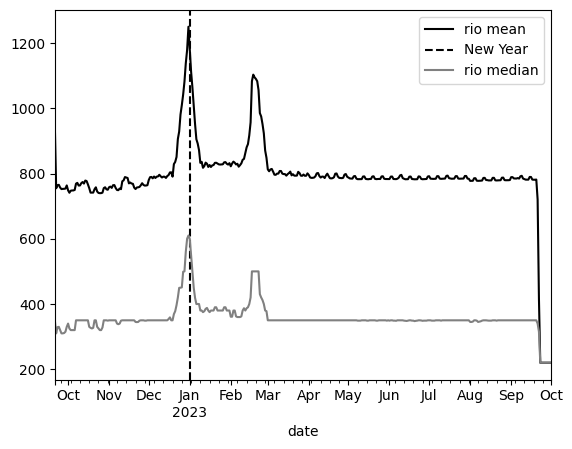

In [13]:
rio_calendar.groupby('date')['price'].mean().plot(color='black')
plt.axvline(x=['2023-01-01'], color='black', linestyle='--')
rio_calendar.groupby('date')['price'].median().plot(color='grey')
plt.legend(['rio mean','New Year','rio median']);

All three datasets show sesonability. Analysis of mean price show that NJ seems to have a high demand season and a low demand season. Both NY and NJ had significant increase in christmans and new year. Rio the end of year price effect lasts longer and there is a long lasting Carnaval effect also. Median price profile for NJ and Rio data have similar profile than median price, but less volatility and day of the week different. In contrast NY median price data show very little sesonability.

*Check the effect of weekday on prices*

In [14]:
#create a columns with weekday
jc_calendar['weekday'] = jc_calendar['date'].dt.dayofweek
nyc_calendar['weekday'] = nyc_calendar['date'].dt.dayofweek
rio_calendar['weekday'] = rio_calendar['date'].dt.dayofweek

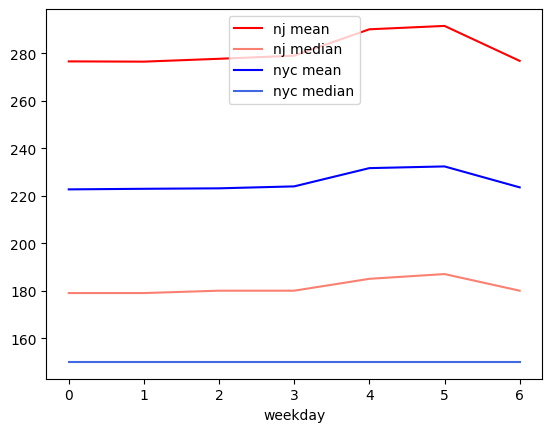

In [15]:
jc_calendar.groupby('weekday')['price'].mean().plot(color = 'r')
jc_calendar.groupby('weekday')['price'].median().plot(color = 'salmon')
nyc_calendar.groupby('weekday')['price'].mean().plot(color = 'b')
nyc_calendar.groupby('weekday')['price'].median().plot(color = 'royalblue')
plt.legend(['nj mean','nj median','nyc mean','nyc median']);
# Monday = 0, Sunday = 6

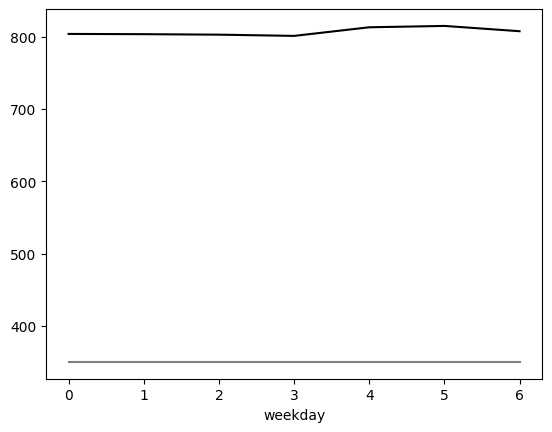

In [16]:
rio_calendar.groupby('weekday')['price'].mean().plot(color = 'black')
rio_calendar.groupby('weekday')['price'].median().plot(color = 'grey');

Nj show clear price differentiation based on the day of the week. Both NY and Rio show price differentiation of average price but no differentiation of median price.

Overal, the analysis sugests that seaonability is correlated to price level. We stratify the data into price segments and check the level of seasonability at each level.

In [17]:
# Selecting price range for stratification
jc_listings.groupby(['bedrooms'])['price'].describe()

,count,mean,std,min,25%,50%,75%,max
bedrooms,,,,,,,,
1.0,1151.0,214.549088,212.947021,20.0,86.00,151.0,300.00,3300.0
2.0,454.0,294.370044,257.177908,41.0,130.00,200.0,388.25,2000.0
3.0,177.0,433.717514,579.000539,64.0,180.00,269.0,398.00,4929.0
4.0,56.0,942.625000,902.160146,100.0,264.00,448.0,1502.25,2850.0
5.0,13.0,685.461538,666.245527,170.0,253.00,442.0,885.00,2671.0
6.0,3.0,748.666667,652.441824,325.0,373.00,421.0,960.50,1500.0
7.0,2.0,650.500000,492.853426,302.0,476.25,650.5,824.75,999.0
8.0,1.0,467.000000,NaN,467.0,467.00,467.0,467.00,467.0
9.0,1.0,1000.000000,NaN,1000.0,1000.00,1000.0,1000.00,1000.0


In [18]:
print(jc_calendar.head(1).T, jc_listings.head(1).T)

                                  0
listing_id                  9329465
date            2022-09-18 00:00:00
available                         f
price                         190.0
adjusted_price                190.0
minimum_nights                  3.0
maximum_nights               1125.0
weekday                           6                                                                                               0
id                                                                                        14175
description                                   3 bed, 1 bath, sleeps 6<br />Three bedroom apa...
host_since                                                                           2009-11-19
host_response_time                                                               within an hour
host_response_rate                                                                         100%
host_acceptance_rate                                                                       100%
host

In [19]:
# Merger of selected columns 
cal = jc_calendar[['listing_id','date','price','weekday']]
listing = jc_listings[['id','bedrooms']]
nj_join = pd.merge(cal,listing, left_on='listing_id', right_on='id')

In [20]:
nj_join.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 739884 entries, 0 to 739883
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   listing_id  739884 non-null  int64         
 1   date        739884 non-null  datetime64[ns]
 2   price       739713 non-null  float64       
 3   weekday     739884 non-null  int64         
 4   id          739884 non-null  int64         
 5   bedrooms    677469 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 39.5 MB


In [21]:
# stratification of NJ listing by bedrooms and price
# 1 bedroom 
nj_strat_1 = nj_join.query('bedrooms == 1')
# 2 bedrooms 
nj_strat_2 = nj_join.query('bedrooms == 2')
# 3 bedrooms
nj_strat_3 =  nj_join.query('bedrooms == 3')

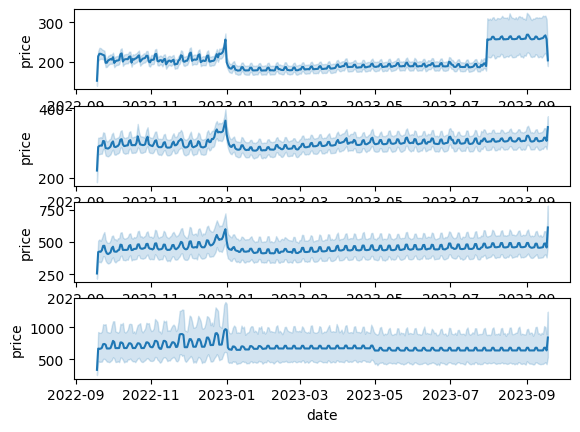

In [22]:
fig, axes = plt.subplots(4,1)
sns.lineplot(x = 'date', y = 'price', data = nj_strat_1, ax =axes[0])
sns.lineplot(x = 'date', y = 'price', data = nj_strat_2, ax =axes[1])
sns.lineplot(x = 'date', y = 'price', data = nj_strat_3, ax =axes[2])
sns.lineplot(x='date', y= 'price', data = nj_join.query('bedrooms > 4'), ax =axes[3]);

Sazonability isn't dependent on number of bedrooms. The most variance happen on begining of year (or begining of time series) listings. Similarly listings are sensitive to the day of the week and end of year holiday. 

In [23]:
arr = [[nj_strat_1.query('date == "2022-12-01"').price.mean(),
      nj_strat_1.query('date == "2022-12-31"').price.mean()],
       [nj_strat_2.query('date == "2022-12-01"').price.mean(),
      nj_strat_2.query('date == "2022-12-31"').price.mean()],
       [nj_strat_3.query('date == "2022-12-01"').price.mean(),
      nj_strat_3.query('date == "2022-12-31"').price.mean()]
      ]
df = pd.DataFrame(arr)
nj_pct_change = df.pct_change(axis=1)[1]

In [24]:
print(df, '\n',nj_pct_change)

            0           1
0  209.627826  256.174783
1  291.801762  364.947137
2  462.966102  599.265537 
 0    0.222046
1    0.250668
2    0.294405
Name: 1, dtype: float64


The end of the year premium is higher than 20% and premium increases with the number of bedrooms. 

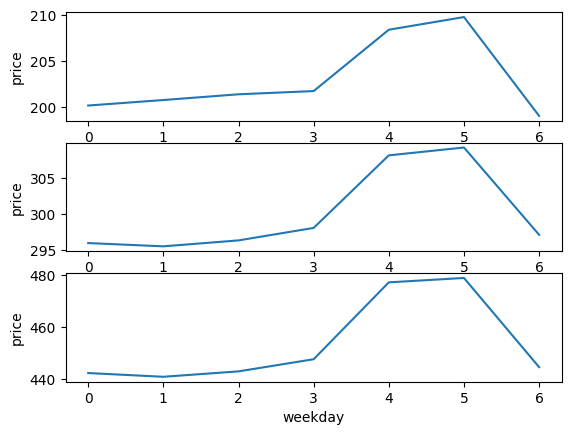

In [25]:
fig, axes = plt.subplots(3,1)
sns.lineplot(nj_strat_1.groupby('weekday')['price'].mean(), ax =axes[0])
sns.lineplot(nj_strat_2.groupby('weekday')['price'].mean(), ax =axes[1])
sns.lineplot(nj_strat_3.groupby('weekday')['price'].mean(), ax =axes[2]);

In [26]:
df = pd.concat([nj_strat_1.groupby('weekday')['price'].mean(),
                  nj_strat_2.groupby('weekday')['price'].mean(),
                  nj_strat_3.groupby('weekday')['price'].mean()], axis=1)

print(df)

              price       price       price
weekday                                    
0        200.129537  295.919059  442.272199
1        200.729026  295.462725  440.836701
2        201.354434  296.291300  442.910365
3        201.706755  298.033802  447.576597
4        208.399157  308.161894  477.099196
5        209.781467  309.257201  478.788353
6        198.998521  297.074992  444.549387


In [27]:
nj_day_pct_change = (df.max() - df.min())/df.min()
print(nj_day_pct_change)

price    0.054186
price    0.046688
price    0.086090
dtype: float64


Friday and Saturnday are the most expensive days, however the premium is relativelly small aroung 5% for 1 and 2 bedrooms and 9% for 3 bedrroms.

In [28]:
cal = nyc_calendar[['listing_id','date','price','weekday']]
listing = nyc_listings[['id','bedrooms']]
nyc_join = pd.merge(cal,listing, left_on='listing_id', right_on='id')

In [29]:
nyc_join.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8255927 entries, 0 to 8255926
Data columns (total 6 columns):
 #   Column      Dtype         
---  ------      -----         
 0   listing_id  int64         
 1   date        datetime64[ns]
 2   price       float64       
 3   weekday     int64         
 4   id          int64         
 5   bedrooms    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 440.9 MB


In [30]:
nyc_listings.groupby(['bedrooms'])['price'].describe()

,count,mean,std,min,25%,50%,75%,max
bedrooms,,,,,,,,
1.0,14410.0,167.030951,317.985245,21.0,76.00,115.0,188.00,10000.0
2.0,4036.0,279.810951,271.157878,10.0,150.00,201.0,305.25,4143.0
3.0,1594.0,375.380803,390.624732,28.0,195.00,272.5,400.00,5000.0
4.0,388.0,686.481959,1067.399609,30.0,293.25,412.5,737.00,16500.0
5.0,92.0,939.130435,1179.478794,65.0,425.00,619.5,973.00,10000.0
6.0,30.0,1088.233333,917.258535,200.0,551.00,741.0,1260.75,3557.0
7.0,10.0,1012.800000,683.670616,545.0,643.00,739.0,1072.50,2800.0
8.0,7.0,1107.428571,524.106496,745.0,824.50,879.0,1118.00,2243.0
9.0,2.0,821.500000,111.015765,743.0,782.25,821.5,860.75,900.0


In [31]:
# stratification of NYC listing by bedrooms and price
# 1 bedroom 
nyc_strat_1 = nyc_join.query('bedrooms == 1')
# 2 bedroom 
nyc_strat_2 = nyc_join.query('bedrooms == 2')
# 3 bedroom 
nyc_strat_3 = nyc_join.query('bedrooms == 3')

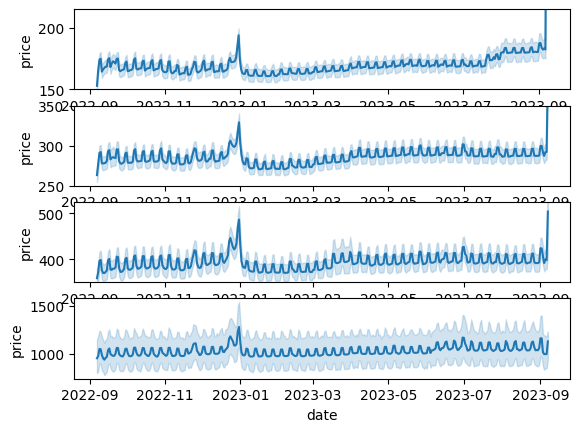

In [32]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,sharey=False)
sns.lineplot(x = 'date', y = 'price', data = nyc_strat_1, ax =ax1)
ax1.set_ylim(150, 215)
sns.lineplot(x = 'date', y = 'price', data = nyc_strat_2, ax =ax2)
ax2.set_ylim(250, 350)
sns.lineplot(x = 'date', y = 'price', data = nyc_strat_3, ax =ax3)
ax3.set_ylim(350, 525)
sns.lineplot(x = 'date', y = 'price', data = nyc_join.query('bedrooms > 4'), ax =ax4);

Similarly to Jersey City, sazonability isn't dependent on number of bedrooms. Listings are sensitive to the day of the week and end of year holiday.

In [33]:
arr = [[nyc_strat_1.query('date == "2022-12-01"').price.mean(),
      nyc_strat_1.query('date == "2022-12-31"').price.mean()],
       [nyc_strat_2.query('date == "2022-12-01"').price.mean(),
      nyc_strat_2.query('date == "2022-12-31"').price.mean()],
       [nyc_strat_3.query('date == "2022-12-01"').price.mean(),
      nyc_strat_3.query('date == "2022-12-31"').price.mean()]
      ]
df = pd.DataFrame(arr)
nyc_pct_change = df.pct_change(axis=1)[1]

In [34]:
print(nyc_pct_change)

0    0.163604
1    0.160109
2    0.244866
Name: 1, dtype: float64


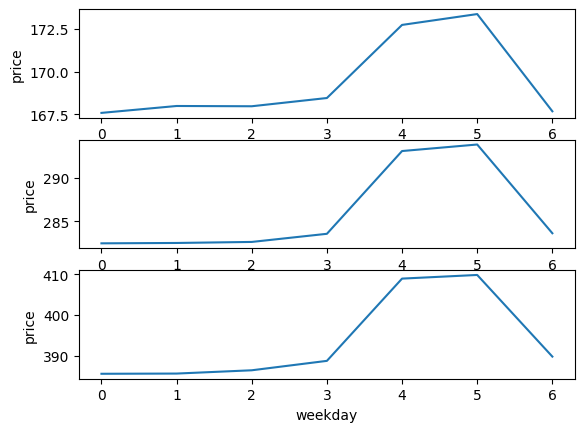

In [35]:
fig, axes = plt.subplots(3,1)
sns.lineplot(nyc_strat_1.groupby('weekday')['price'].mean(), ax =axes[0])
sns.lineplot(nyc_strat_2.groupby('weekday')['price'].mean(), ax =axes[1])
sns.lineplot(nyc_strat_3.groupby('weekday')['price'].mean(), ax =axes[2]);

Friday and Saturnday are the most expensive days, however the premium is relativelly small aroung 4% for 1 and 2 bedrooms and 6% for 3 bedrroms.

In [36]:
df = pd.concat([nyc_strat_1.groupby('weekday')['price'].mean(),
                  nyc_strat_2.groupby('weekday')['price'].mean(),
                  nyc_strat_3.groupby('weekday')['price'].mean()], axis=1)

print(df)

              price       price       price
weekday                                    
0        167.584664  282.446934  385.536531
1        167.987826  282.489336  385.589760
2        167.972158  282.608633  386.395636
3        168.453689  283.549967  388.711503
4        172.725897  293.127506  408.922474
5        173.360265  293.882667  409.818635
6        167.677510  283.613693  389.759109


In [37]:
nyc_day_pct_change = (df.max() - df.min())/df.min()
print(nyc_day_pct_change)

price    0.034464
price    0.040488
price    0.062983
dtype: float64


In [38]:
cal = rio_calendar[['listing_id','date','price','weekday']]
listing = rio_listings[['id','bedrooms']]
rio_join = pd.merge(cal,listing, left_on='listing_id', right_on='id')

In [39]:
rio_join.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8496375 entries, 0 to 8496374
Data columns (total 6 columns):
 #   Column      Dtype         
---  ------      -----         
 0   listing_id  int64         
 1   date        datetime64[ns]
 2   price       float64       
 3   weekday     int64         
 4   id          int64         
 5   bedrooms    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 453.8 MB


In [40]:
# Selecting price range for stratification
rio_listings.groupby(['bedrooms'])['price'].describe()

,count,mean,std,min,25%,50%,75%,max
bedrooms,,,,,,,,
1.0,12246.0,464.652540,4106.403068,40.0,150.0,230.0,358.75,335103.0
2.0,6106.0,737.162299,1891.434099,48.0,290.0,450.0,800.00,100000.0
3.0,2730.0,1217.154579,3133.680076,60.0,452.5,707.5,1241.25,100000.0
4.0,665.0,2596.759398,4876.963122,70.0,800.0,1500.0,3000.00,100000.0
5.0,207.0,4696.521739,8501.356812,80.0,1182.0,2200.0,4704.00,79255.0
6.0,108.0,3939.694444,4610.451178,70.0,1200.0,2650.0,5500.00,40000.0
7.0,34.0,3609.029412,3991.243882,163.0,1164.0,2200.5,4710.25,15343.0
8.0,13.0,5065.000000,4079.808125,906.0,2329.0,4000.0,7357.00,16000.0
9.0,11.0,5655.363636,3412.055752,70.0,3363.0,6250.0,7506.00,11100.0


In [41]:
# stratification of NYC listing by bedrooms and price
# 1 bedroom 
rio_strat_1 = rio_join.query('bedrooms == 1')
# 2 bedroom 
rio_strat_2 = rio_join.query('bedrooms == 2')
# 3 bedroom 
rio_strat_3 = rio_join.query('bedrooms == 3')

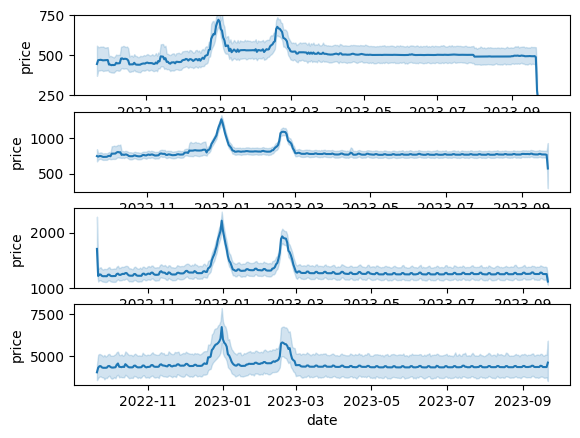

In [42]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,sharey=False)
sns.lineplot(x = 'date', y = 'price', data = rio_strat_1, ax =ax1)
ax1.set_ylim(250,750)
sns.lineplot(x = 'date', y = 'price', data = rio_strat_2, ax =ax2)
sns.lineplot(x = 'date', y = 'price', data = rio_strat_3, ax =ax3)
sns.lineplot(x = 'date', y = 'price', data = rio_join.query('bedrooms > 4'), ax =ax4);

Rio, sazonality is marked by bimodal distribution. Besides end of year holidays, Carnaval affects listing prices significantly. The figure shows the existance on weekdays sazonality also. In addition, the price premium for end of year abd carnaval is significantly higher than Jersey City and New York. Rio listing end of year premium is over 60% and 30% for carnaval.

In [43]:
arr = [[rio_strat_1.query('date == "2022-12-01"').price.mean(),
      rio_strat_1.query('date == "2022-12-31"').price.mean()],
       [rio_strat_2.query('date == "2022-12-01"').price.mean(),
      rio_strat_2.query('date == "2022-12-31"').price.mean()],
       [rio_strat_3.query('date == "2022-12-01"').price.mean(),
      rio_strat_3.query('date == "2022-12-31"').price.mean()],
       [rio_strat_1.query('date == "2023-02-01"').price.mean(),
      rio_strat_1.query('date == "2023-02-18"').price.mean()],
       [rio_strat_2.query('date == "2023-02-01"').price.mean(),
      rio_strat_2.query('date == "2023-02-18"').price.mean()],
       [rio_strat_3.query('date == "2023-02-01"').price.mean(),
      rio_strat_3.query('date == "2023-02-18"').price.mean()]
      ]
df = pd.DataFrame(arr)
rio_pct_change = df.pct_change(axis=1)[1]

In [44]:
print(rio_pct_change)

0    0.539893
1    0.601978
2    0.723901
3    0.299376
4    0.343910
5    0.464869
Name: 1, dtype: float64


In [45]:
rio_end_year = rio_pct_change[0:3]
rio_carnaval = rio_pct_change[3:].reset_index(drop=True)


In [46]:
rio_carnaval

0    0.299376
1    0.343910
2    0.464869
Name: 1, dtype: float64

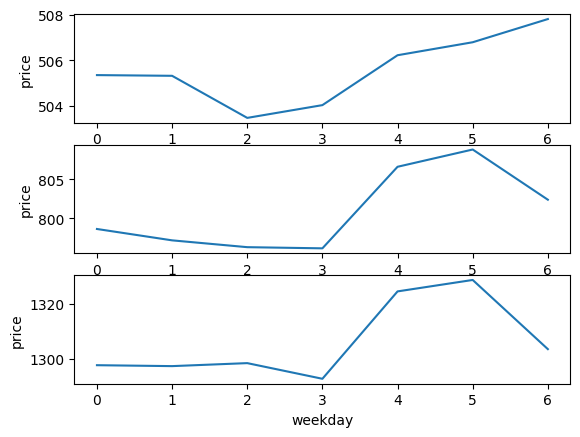

In [47]:
fig, axes = plt.subplots(3,1)
sns.lineplot(rio_strat_1.groupby('weekday')['price'].mean(), ax =axes[0])
sns.lineplot(rio_strat_2.groupby('weekday')['price'].mean(), ax =axes[1])
sns.lineplot(rio_strat_3.groupby('weekday')['price'].mean(), ax =axes[2]);

Friday and Saturday have a small premium, rio weekday sazonality is the lowest among the cities studied.

In [48]:
df = pd.concat([rio_strat_1.groupby('weekday')['price'].mean(),
                rio_strat_2.groupby('weekday')['price'].mean(),
                rio_strat_3.groupby('weekday')['price'].mean()], axis=1)

print(df)

              price       price        price
weekday                                     
0        505.344601  798.636795  1297.638955
1        505.313567  797.180040  1297.301895
2        503.465537  796.306506  1298.394474
3        504.026015  796.157096  1292.686904
4        506.217409  806.609090  1324.543632
5        506.787590  808.822202  1328.714243
6        507.805783  802.388184  1303.494780


In [49]:
rio_day_pct_change = (df.max() - df.min())/df.min()
print(rio_day_pct_change)

price    0.008621
price    0.015908
price    0.027870
dtype: float64


Saving sazonality data

In [50]:
data = {'Jersey City': nj_pct_change, 
        'NYC':nyc_pct_change,
        'Rio':rio_end_year,
        'Rio_carnaval':rio_carnaval}
sazonal = pd.concat(data, axis =1, )

In [51]:
sazonal['bedrooms'] = [1,2,3]
sazonal.set_index(keys='bedrooms', inplace=True)
print(sazonal)

          Jersey City       NYC       Rio  Rio_carnaval
bedrooms                                               
1            0.222046  0.163604  0.539893      0.299376
2            0.250668  0.160109  0.601978      0.343910
3            0.294405  0.244866  0.723901      0.464869


In [52]:
sazonal.to_pickle(path_data+'sazonal.pkl')

In [53]:
day_data = {'Jersey City': nj_day_pct_change,
           'NYC': nyc_day_pct_change,
           'Rio': rio_day_pct_change}
sazonal_day = pd.concat(day_data, axis=1)

In [54]:
print(sazonal_day)

       Jersey City       NYC       Rio
price     0.054186  0.034464  0.008621
price     0.046688  0.040488  0.015908
price     0.086090  0.062983  0.027870


In [55]:
sazonal_day.to_pickle(path_data+'sazonal_day.pkl')